## Imports and Options

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)

In [4]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])
closure_col_idx = OrderedDict([("inducer_concentration", 0), ("timepoint", 1), ("percent_live", 2)])

## Utility Functions

In [5]:
def training_progress(fitted_model, metrics, num_plots, plot_val=None):
    '''
    A function for plotting the model history by showing the metric and loss throughout training
    '''
    plt.subplot(1, num_plots, 2)
    plt.plot(fitted_model.history['loss'], label='train loss')
    if plot_val is not None:
        plt.plot(fitted_model.history['val_loss'], label='val loss')
    plt.title('Loss')
    plt.legend()

    for i, metric in enumerate(metrics):
        subplot_number = i + 3
        plt.subplot(1, num_plots, subplot_number)
        plt.plot(fitted_model.history[metric], label=str(metric))
        if plot_val is not None:
            plt.plot(fitted_model.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(str(metric))
        plt.legend()

    plt.show()


def plot_model_result(model, fitted_model, metrics, train, test, feature_cols, plot_val=None):
    '''
    plot the foe_probabilities of a model
    plot the training history
    show training and testing accuracy
    '''
    num_plots = len(metrics) + 2
    probas = model.predict_proba(train[feature_cols])
    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_plots, 1)
    plt.hist(probas)
    plt.xlabel('predict_proba')
    training_progress(fitted_model, metrics, num_plots, plot_val)

# Begin Debug

## Prepare Data

In [6]:
df = pd.read_csv("models/cfu_neural_network/df_for_testing.csv")
print(df.shape, "\n")

# df = df.loc[df["timepoint"].isin([1.0])]
# df = df.loc[df["inducer_concentration"].isin([5.0])]

# df = df.loc[df[n.timepoint].isin([6.0, 1.0])]
# df = df.loc[df[n.inducer_concentration].isin([0.0, 80.0, 5.0])]

df = df.loc[df[n.timepoint].isin([6.0])]
df = df.loc[df[n.inducer_concentration].isin([0.0, 80.0,])]
df = df.sample(frac=1)
df1 = df[df[n.inducer_concentration]==0.0].sample(1000)
df2 = df[df[n.inducer_concentration]==80.0].sample(1000)
df = pd.concat([df1, df2])

# changing the percent_live values to see if cfu_loss can nudge in the right direction.
# can't use 0% and 100% because the bin_cross will already predict labels that match with that pretty well.
# df.loc[df[n.percent_live] == 0.0, n.percent_live] = 30.0
# df.loc[df[n.percent_live] == 100.0, n.percent_live] = 70.0


print(df[n.inducer_concentration].value_counts(), "\n")
print(df["label"].value_counts(), "\n")
print(df[n.percent_live].value_counts(), "\n")


features = n.morph_cols
X = df[features]
Y = df[col_idx.keys()]
Y_labels = df[n.label]

# Y_closure = df[n.label]
# Z_closure = tf.convert_to_tensor(df[[n.inducer_concentration, n.timepoint, n.percent_live]])

# print(Y["inducer_concentration"].value_counts(), "\n")
# print(Y["timepoint"].value_counts(), "\n")
# print(Y["percent_live"].value_counts(), "\n")

(259542, 10) 

80.0    1000
0.0     1000
Name: inducer_concentration, dtype: int64 

0.0    1035
1.0     965
Name: label, dtype: int64 

0.0      1000
100.0    1000
Name: percent_live, dtype: int64 



## Version 0: Test bin_cross function only

In [32]:
def bin_cross_v0(label_conds_cfus, y_pred):
    y_pred = K.flatten(y_pred)
    y_true = label_conds_cfus[:, col_idx[n.label]]
    final_loss = tf.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred)
    return final_loss

In [33]:
def labeling_booster_model_v0(input_shape=None, loss=bin_cross_v0):
    model = Sequential()
    model.add(Dropout(0.1, input_shape=(input_shape,)))
    # wr = l1_l2(l2=0.02, l1=0)
    wr = None
    model.add(Dense(units=32, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.3))
    model.add(Dense(units=16, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=4, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    # wr = l1_l2(l2=0.02, l1=0)
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=wr))
    model.add(Flatten())
    model.compile(loss=loss, optimizer=Adam(lr=0.01),
                  metrics=[loss], run_eagerly=True)
    # TODO: figure out how to add accuracy to metrics. Not trivial due to 4D nature of our Y.
    return model


Model Boosting took 12.459909915924072 seconds

Training Accuracy = 95.85%

Counter({1: 1048, 0: 952})


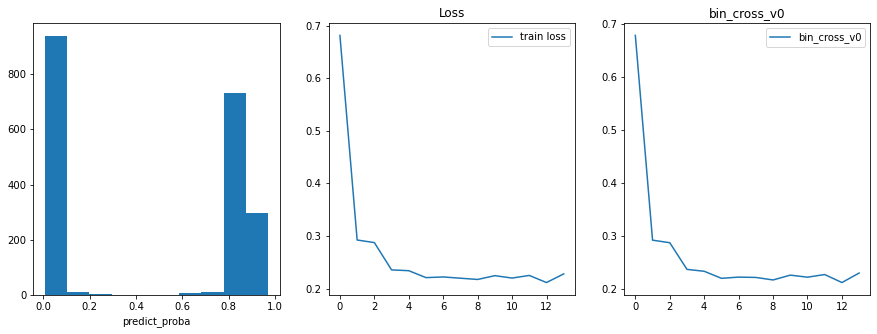

In [37]:
# Set loss:
loss = bin_cross_v0

del model
tf.compat.v1.reset_default_graph
tf.keras.backend.clear_session()

start_time = time.time()
model = labeling_booster_model_v0(input_shape=len(features), loss=loss)

fitted_model = model.fit(X, Y, epochs=14, batch_size=32, verbose=False, shuffle=True)
predict_proba = model.predict(X)
class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
print("\nModel Boosting took {} seconds".format(time.time() - start_time))
print("\nTraining Accuracy = {}%\n".format(round(100 * training_accuracy, 2)))
print(Counter(class_predictions))

plot_model_result(model=model, fitted_model=fitted_model,
                  metrics=[x.__name__ for x in [loss]],
                  train=df, test=df, feature_cols=features, plot_val=None)


Model Boosting took 12.055702924728394 seconds

Training Accuracy = 95.95%

Counter({1: 1046, 0: 954})


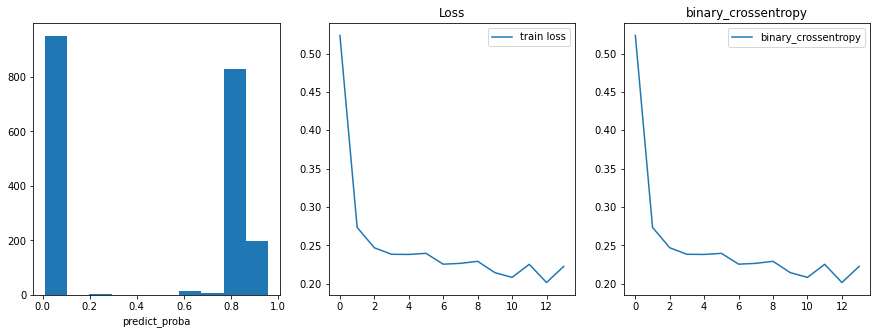

In [36]:
# Set loss:
loss = "binary_crossentropy"

del model
tf.compat.v1.reset_default_graph
tf.keras.backend.clear_session()

start_time = time.time()
model = labeling_booster_model_v0(input_shape=len(features), loss=loss)

fitted_model = model.fit(X, Y_labels, epochs=14, batch_size=32, verbose=False, shuffle=True)
predict_proba = model.predict(X)
class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
print("\nModel Boosting took {} seconds".format(time.time() - start_time))
print("\nTraining Accuracy = {}%\n".format(round(100 * training_accuracy, 2)))
print(Counter(class_predictions))

plot_model_result(model=model, fitted_model=fitted_model,
                  metrics=[loss],
                  train=df, test=df, feature_cols=features, plot_val=None)

## Version 1

In [19]:
def cfu_loss_v1(label_conds_cfus, y_pred):
    cfu_percent_live = label_conds_cfus[:, col_idx["percent_live"]]
#     print("cfu_percent_live shape: {}".format(cfu_percent_live.shape))
    cfu_percent_live = tf.expand_dims(cfu_percent_live, axis=1)
#     print("cfu_percent_live shape: {}".format(cfu_percent_live.shape))

    condition_indices = [col_idx["inducer_concentration"], col_idx["timepoint"]]
    conditions = tf.gather(label_conds_cfus, condition_indices, axis=1)
#     print("condition_indices: {}".format(condition_indices))
#     print("conditions shape: {}".format(conditions.shape))

#     print("y_pred shape: {}".format(y_pred.shape))
    y_pred = tf.sigmoid((y_pred - 0.5) * 100)
#     print("y_pred shape: {}".format(y_pred.shape))

    uniques, idx, count = gen_array_ops.unique_with_counts_v2(conditions, [0])
#     print("uniques shape: {}".format(uniques.shape))

    num_unique = tf.size(count)
    sums = tf.math.unsorted_segment_sum(data=y_pred, segment_ids=idx, num_segments=num_unique)
#     print("sums shape: {}".format(sums.shape))
    lengths = tf.cast(count, tf.float32)
#     print("lengths shape: {}".format(lengths.shape))
    pred_percents = 100.0 * tf.divide(sums, lengths)  # check if I need to do multiplication via backend function
#     print("pred_percents shape: {}".format(pred_percents.shape))

    pred_percents_mean = tf.math.reduce_mean(pred_percents)
    percents_live_mean = tf.math.reduce_mean(cfu_percent_live)
#     print("pred_percents_mean shape: {}".format(pred_percents_mean.shape))
#     print("percents_live_mean shape: {}".format(percents_live_mean.shape))
    diff = pred_percents_mean - percents_live_mean  # TODO: check if need backend function
#     print("diff:\n{}\n".format(diff))
    final = K.abs(diff / 100.0)
#     print("abs(diff/100.0):\n{}\n".format(final))
#     print("-"*50, "\n")

    return final

In [14]:
def joint_loss_v1(label_conds_cfus, y_pred):
    loss_bin_cross = bin_cross(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
    loss_cfu = cfu_loss(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
    # loss_cfu = cfu_loss_2(label_conds_cfus=label_conds_cfus, y_pred=y_pred)

    return loss_bin_cross + 3 * loss_cfu
    # return loss_bin_cross
    # return loss_cfu

In [ ]:
def labeling_booster_model_v1(input_shape=None, loss=joint_loss_v1):
    model = Sequential()
    model.add(Dropout(0.1, input_shape=(input_shape,)))
    # wr = l1_l2(l2=0.02, l1=0)
    wr = None
    model.add(Dense(units=32, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.3))
    model.add(Dense(units=16, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=4, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    # wr = l1_l2(l2=0.02, l1=0)
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=wr))
    model.add(Flatten())
    model.compile(loss=loss, optimizer="Adam",
                  metrics=[loss], run_eagerly=True)
    # TODO: figure out how to add accuracy to metrics. Not trivial due to 4D nature of our Y.
    return model

In [ ]:
# Set loss:
loss = cfu_loss_v1

del model
tf.compat.v1.reset_default_graph
tf.keras.backend.clear_session()

# set model:
model = labeling_booster_model_v1(input_shape=len(features), loss=loss)

start_time = time.time()
fitted_model = model.fit(X, Y, epochs=5, batch_size=16, verbose=True, shuffle=True)
predict_proba = model.predict(X)
class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
print("\nModel Boosting took {} seconds".format(time.time() - start_time))
print("\nTraining Accuracy = {}%\n".format(round(100 * training_accuracy, 2)))
print(Counter(class_predictions), "\n")

plot_model_result(model=model, fitted_model=fitted_model,
                  metrics=[x.__name__ for x in [loss]],
                  train=df, test=df, feature_cols=features)

## Version 2: Flattened shape of sums

In [18]:
def cfu_loss_v2(label_conds_cfus, y_pred):
    cfu_percent_live = label_conds_cfus[:, col_idx["percent_live"]]
    cfu_percent_live = tf.expand_dims(cfu_percent_live, axis=1)
#     print("cfu_percent_live:\n{}\n".format(cfu_percent_live))

    condition_indices = [col_idx["inducer_concentration"], col_idx["timepoint"]]
    conditions = tf.gather(label_conds_cfus, condition_indices, axis=1)
#     print("conditions:\n{}\n".format(conditions))

#     print("y_pred:\n{}\n".format(y_pred))
    y_pred = tf.sigmoid((y_pred - 0.5) * 100)
#     print("y_pred after sigmoid:\n{}\n".format(y_pred))

    uniques, idx, count = gen_array_ops.unique_with_counts_v2(conditions, [0])

    num_unique = tf.size(count)
    sums = tf.math.unsorted_segment_sum(data=y_pred, segment_ids=idx, num_segments=num_unique)
    sums = K.flatten(sums)
#     print("sums:\n{}\n".format(sums))
    lengths = tf.cast(count, tf.float32)
#     print("lengths:\n{}\n".format(lengths))
    pred_percents = 100.0 * tf.divide(sums, lengths)
#     print("pred_percents:\n{}\n".format(pred_percents))

    pred_percents_mean = tf.math.reduce_mean(pred_percents)
    percents_live_mean = tf.math.reduce_mean(cfu_percent_live)
#     print("pred_percents_mean:\n{}\n".format(pred_percents_mean))
#     print("percents_live_mean:\n{}\n".format(percents_live_mean))
    diff = pred_percents_mean - percents_live_mean
#     print("diff:\n{}\n".format(diff))
    final = K.abs(diff / 100.0)
#     print("abs(diff/100.0):\n{}\n".format(final))
#     print("-"*50, "\n")

    return final

In [ ]:
def joint_loss_v2(label_conds_cfus, y_pred):
    loss_bin_cross = bin_cross_v0(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
    loss_cfu = cfu_loss_v2(label_conds_cfus=label_conds_cfus, y_pred=y_pred)
    return loss_bin_cross + loss_cfu

In [ ]:
def labeling_booster_model_v2(input_shape=None, loss=joint_loss_v1):
    model = Sequential()
    model.add(Dropout(0.1, input_shape=(input_shape,)))
    # wr = l1_l2(l2=0.02, l1=0)
    wr = None
    model.add(Dense(units=32, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.3))
    model.add(Dense(units=16, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=4, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    # wr = l1_l2(l2=0.02, l1=0)
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=wr))
    model.add(Flatten())
    model.compile(loss=loss, optimizer="Adam",
                  metrics=[loss], run_eagerly=True)
    # TODO: figure out how to add accuracy to metrics. Not trivial due to 4D nature of our Y.
    return model

In [ ]:
# Set loss:
loss = cfu_loss_v2

del model
tf.compat.v1.reset_default_graph
tf.keras.backend.clear_session()

# set model:
model = labeling_booster_model_v2(input_shape=len(features), loss=loss)

start_time = time.time()
fitted_model = model.fit(X, Y, epochs=5, batch_size=8, verbose=True, shuffle=True)
predict_proba = model.predict(X)
class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
print("\nModel Boosting took {} seconds".format(time.time() - start_time))
print("\nTraining Accuracy = {}%\n".format(round(100 * training_accuracy, 2)))
print(Counter(class_predictions), "\n")

plot_model_result(model=model, fitted_model=fitted_model,
                  metrics=[x.__name__ for x in [loss]],
                  train=df, test=df, feature_cols=features)

## Version 3: Simplified Loss and Fixed Issue with Absolute Value of Differences

Description:
- Thanks to Yi-Pei, we realized that there was an issue at the tail end of our CFU loss: percent_live predictions and cfu values were being meaned across conditions, and then the absolute difference was being taken. This is not what we want, instead we want the absolute difference to be taken between the percent_live predictions and cfu value in each condition, and then those absolute differences should be meaned. Initial implementation did not include absolute value, and so the code was written in the way it was because a difference of means is the same as a mean of differences. But that is not the case when absolute value is brought into account.
- Removed extraneous multiplication and division by 100.
- Replaced unsorted_segment_sum and division by length with unsorted_segment_mean for cleaner and more manageable code.

In [46]:
def cfu_loss_v3(label_conds_cfus, y_pred):
    cfu_percent_live = label_conds_cfus[:, col_idx["percent_live"]]
    cfu_percent_live = cfu_percent_live / 100.0
#     print("cfu_percent_live:\n{}\n".format(cfu_percent_live))

    condition_indices = [col_idx["inducer_concentration"], col_idx["timepoint"]]
    conditions = tf.gather(label_conds_cfus, condition_indices, axis=1)
#     print("conditions:\n{}\n".format(conditions))

    y_pred = K.flatten(y_pred)
#     print("y_pred:\n{}\n".format(y_pred))
    y_pred = tf.sigmoid((y_pred - 0.5) * 100)
#     print("y_pred after sigmoid:\n{}\n".format(y_pred))

    uniques, idx, count = gen_array_ops.unique_with_counts_v2(conditions, [0])

    num_unique = tf.size(count)
    pred_percents = tf.math.unsorted_segment_mean(data=y_pred, segment_ids=idx, num_segments=num_unique)
#     print("pred_percents:\n{}\n".format(pred_percents))
    
    cfu_percents = tf.math.unsorted_segment_mean(data=cfu_percent_live, segment_ids=idx, num_segments=num_unique)
#     print("cfu_percents:\n{}\n".format(cfu_percents))
    
    diff = tf.math.subtract(pred_percents, cfu_percents)
#     print("diff:\n{}\n".format(diff))
    
    abs_diff = K.abs(diff)
#     print("abs_diff:\n{}\n".format(abs_diff))

    abs_diff_mean = tf.math.reduce_mean(abs_diff)
#     print("abs_diff_mean:\n{}\n".format(abs_diff_mean))
#     print("-"*50, "\n")

    return abs_diff_mean

In [47]:
def labeling_booster_model_v3(input_shape=None, loss=joint_loss_v1):
    model = Sequential()
    model.add(Dropout(0.1, input_shape=(input_shape,)))
    # wr = l1_l2(l2=0.02, l1=0)
    wr = None
    model.add(Dense(units=32, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.3))
    model.add(Dense(units=16, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=4, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    # wr = l1_l2(l2=0.02, l1=0)
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=wr))
    model.add(Flatten())
    model.compile(loss=loss, optimizer=Adam(lr=0.01),
                  metrics=[loss], run_eagerly=True)
    # TODO: figure out how to add accuracy to metrics. Not trivial due to 4D nature of our Y.
    return model


Model Boosting took 14.836790084838867 seconds

Training Accuracy = 95.05%

Counter({1: 1064, 0: 936})


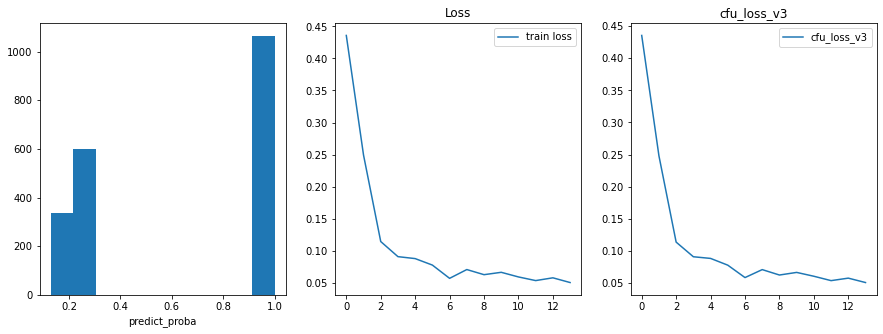

                                 percent_live  nn_preds
inducer_concentration timepoint                        
0.0                   6.0               100.0      99.6
80.0                  6.0                 0.0       6.8


In [51]:
# Set loss:
loss = cfu_loss_v3

del model
tf.compat.v1.reset_default_graph
tf.keras.backend.clear_session()

# set model:
model = labeling_booster_model_v3(input_shape=len(features), loss=loss)

start_time = time.time()
fitted_model = model.fit(X, Y, epochs=14, batch_size=32, verbose=False, shuffle=True)
predict_proba = model.predict(X)
class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
print("\nModel Boosting took {} seconds".format(time.time() - start_time))
print("\nTraining Accuracy = {}%\n".format(round(100 * training_accuracy, 2)))
print(Counter(class_predictions))

plot_model_result(model=model, fitted_model=fitted_model,
                  metrics=[x.__name__ for x in [loss]],
                  train=df, test=df, feature_cols=features)

preds_and_labels = Y.copy()
preds_and_labels.drop(columns=[n.label], inplace=True)
preds_and_labels["nn_preds"] = class_predictions * 100

grouby_means = preds_and_labels.groupby([n.inducer_concentration, n.timepoint]).mean()
print(grouby_means)

In [52]:
# changing the percent_live values to see if cfu_loss can nudge in the right direction.
# can't use 0% and 100% because the bin_cross will already predict labels that match with that pretty well.
new_df = df.copy()
original_percent_live = new_df[n.percent_live].copy()
new_df.loc[new_df[n.percent_live] == 0.0, n.percent_live] = 90.0
new_df.loc[new_df[n.percent_live] == 100.0, n.percent_live] = 10.0

X_new = new_df[features]
Y_new = new_df[col_idx.keys()]
# display(new_df)


Model Boosting took 14.579313278198242 seconds

Training Accuracy = 4.25%

Counter({0: 1050, 1: 950})


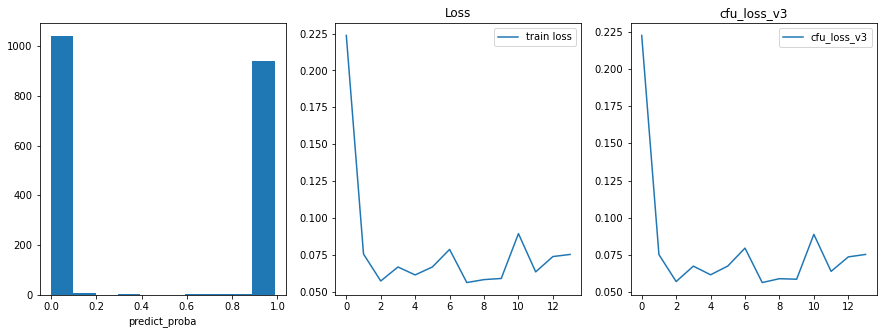

                                 original_percent_live  altered_percent_live  nn_preds
inducer_concentration timepoint                                                       
0.0                   6.0                        100.0                  10.0       0.4
80.0                  6.0                          0.0                  90.0      94.6


In [53]:
# Set loss:
loss = cfu_loss_v3

del model
tf.compat.v1.reset_default_graph
tf.keras.backend.clear_session()

# set model:
model = labeling_booster_model_v3(input_shape=len(features), loss=loss)

start_time = time.time()
fitted_model = model.fit(X_new, Y_new, epochs=14, batch_size=32, verbose=False, shuffle=True)
predict_proba = model.predict(X)
class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
print("\nModel Boosting took {} seconds".format(time.time() - start_time))
print("\nTraining Accuracy = {}%\n".format(round(100 * training_accuracy, 2)))
print(Counter(class_predictions))

plot_model_result(model=model, fitted_model=fitted_model,
                  metrics=[x.__name__ for x in [loss]],
                  train=df, test=df, feature_cols=features)

preds_and_labels = Y_new.copy()
preds_and_labels.drop(columns=[n.label], inplace=True)
preds_and_labels["nn_preds"] = class_predictions * 100
preds_and_labels.insert(2,"original_percent_live", original_percent_live)
preds_and_labels.rename(columns={"percent_live":"altered_percent_live"}, inplace=True)

grouby_means = preds_and_labels.groupby([n.inducer_concentration, n.timepoint]).mean()
print(grouby_means)

### Function closure: testing closure_loss

In [ ]:
def closure_booster_model(input_shape=None, loss=joint_loss):
    model = Sequential()
    i = Input((1,))
    model.add(Dropout(0.1, input_shape=(input_shape,)))
    # wr = l1_l2(l2=0.02, l1=0)
    wr = None
    model.add(Dense(units=32, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.3))
    model.add(Dense(units=16, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=4, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    # wr = l1_l2(l2=0.02, l1=0)
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=wr))
    model.add(Flatten())
    model.compile(loss=loss, optimizer="Adam",
                  metrics=["accuracy"], run_eagerly=True)
    # TODO: figure out how to add accuracy to metrics. Not trivial due to 4D nature of our Y.
    return model

In [ ]:
def closure_loss(conds_cfus):    
    def loss(y_true, y_pred):
        cfu_percent_live = conds_cfus[:, closure_col_idx[n.percent_live]]
        cfu_percent_live = tf.expand_dims(cfu_percent_live, axis=1)

        condition_indices = [closure_col_idx[n.inducer_concentration], closure_col_idx[n.timepoint]]
        conditions = tf.gather(conds_cfus, condition_indices, axis=1)

        y_pred = tf.sigmoid((y_pred - 0.5) * 1000)

        uniques, idx, count = gen_array_ops.unique_with_counts_v2(conditions, [0])

        num_unique = tf.size(count)
        sums = tf.math.unsorted_segment_sum(data=y_pred, segment_ids=idx, num_segments=num_unique)
        
        lengths = tf.cast(count, tf.float32)
        pred_percents = 100.0 * tf.divide(sums, lengths)

        pred_percents_mean = tf.math.reduce_mean(pred_percents)
        percents_live_mean = tf.math.reduce_mean(cfu_percent_live)
        diff = pred_percents_mean - percents_live_mean
        # print(pred_percents_mean, percents_live_mean, diff)

        cfu_loss = K.abs(diff / 100.0)
        
        
        return tf.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred) + cfu_loss

    return loss

In [ ]:
start_time = time.time()
model = closure_booster_model(input_shape=len(features), loss=closure_loss(Z_closure))

fitted_model = model.fit(X, Y, epochs=25, batch_size=128, verbose=False, shuffle=True)
predict_proba = model.predict(X)
class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
training_accuracy = accuracy_score(y_true=Y[n.label], y_pred=class_predictions)
print("\nModel Boosting took {} seconds".format(time.time() - start_time))
print("\nTraining Accuracy = {}%\n".format(round(100 * training_accuracy, 2)))
print(Counter(class_predictions), "\n")

plot_model_result(model=model, fitted_model=fitted_model,
                  metrics=["binary_crossentropy", "accuracy"],
                  train=df, test=df, feature_cols=features)